In [1]:
from comet_ml import Experiment
experiment = Experiment(
    api_key="91nnAun2dj21K2NJIR8vmC3Dk",
    project_name="mae5904-rna",
    workspace="martinoni",
)
from pandas import read_csv, get_dummies, to_datetime
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import plot_model
from numpy import abs



COMET INFO: Experiment is live on comet.ml https://www.comet.ml/martinoni/mae5904-rna/0745bc109bcb4267a73389b9350535d4



## Leitura dos dados

In [2]:
dados = read_csv('dados.csv', sep=',', encoding='latin-1')
dados

/home/martinoni/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,resultadoTeste,sexo,idade,Assintomatico,Coriza,Dispneia,DistGustativos,DistOlfativos,DorDeCabeca,DorDeGarganta,Febre,Tosse,Outros,profissionalSaude,dataNotificacao,municipioIBGE,municipioNotificacaoIBGE
0,1,Negativo,Feminino,53,0,0,1,0,0,0,0,0,0,0,Não,2020-09-30,3524709,3524709
1,2,Negativo,Feminino,18,0,0,0,0,0,1,1,1,1,0,Não,2020-10-06,3513504,3513504
2,3,Negativo,Masculino,28,0,1,0,0,0,1,1,1,0,0,Não,2020-09-30,3504107,3504107
3,4,Positivo,Masculino,27,0,0,0,0,0,0,0,0,1,1,Não,2020-10-08,3522307,3522307
4,5,Negativo,Masculino,54,0,0,0,0,0,0,0,0,0,1,Não,2020-10-15,3509007,3550308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280697,280698,Negativo,Masculino,77,0,1,0,0,0,1,0,1,1,1,Não,2020-09-18,3550308,3550308
280698,280699,Negativo,Masculino,20,0,0,0,0,0,0,1,0,0,0,Não,2020-10-20,3549805,3549805
280699,280700,Negativo,Feminino,35,0,0,0,1,1,0,0,0,1,1,Não,2020-10-20,3538709,3538709
280700,280701,Negativo,Masculino,33,0,1,1,1,1,1,1,1,1,0,Não,2020-10-13,3505708,3505708


## Ordenação dos dados por data de notificação

In [3]:
dados = dados.drop('Unnamed: 0', axis=1)
dados['dataNotificacao'] = to_datetime(dados.dataNotificacao)
dados = dados.sort_values('dataNotificacao', ignore_index=True)
dados

,resultadoTeste,sexo,idade,Assintomatico,Coriza,Dispneia,DistGustativos,DistOlfativos,DorDeCabeca,DorDeGarganta,Febre,Tosse,Outros,profissionalSaude,dataNotificacao,municipioIBGE,municipioNotificacaoIBGE
0,Positivo,Feminino,22,0,0,1,1,1,0,0,0,0,1,Não,2020-06-02,3550308,3550308
1,Positivo,Masculino,66,0,0,0,0,0,0,0,0,1,1,Não,2020-06-02,3550308,3550308
2,Positivo,Masculino,45,0,0,0,0,0,0,0,0,1,1,Não,2020-06-02,3529401,3547809
3,Positivo,Feminino,19,0,0,0,0,0,0,1,1,1,1,Não,2020-06-02,3509700,3509700
4,Negativo,Feminino,38,0,0,0,0,0,0,1,0,1,1,Não,2020-06-02,3512407,3512407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280697,Negativo,Feminino,50,0,0,0,0,0,0,1,0,1,0,Não,2020-11-03,3513702,3513702
280698,Positivo,Masculino,27,0,0,0,0,0,0,0,0,1,0,Não,2020-11-03,3536505,3536505
280699,Negativo,Feminino,89,0,0,1,0,0,0,0,1,0,0,Não,2020-11-03,3513702,3513702
280700,Negativo,Masculino,44,0,1,0,0,0,0,1,1,0,0,Não,2020-11-03,3539301,3539301


## Quais variáveis podemos usar na nossa rede neural?

* Fatores (input)
    1. Sexo
    2. Sintomas (Assintomático, Coriza, Dispneia...)
    3. municipioIBGE
    4. municipioNotificacaoIBGE
    
    
* Escalar (input)
    1. idade
    
    

* Variável Resposta (output)
    1. resultadoTeste (1=Positivo; 0=Negativo)


In [4]:
dados = dados.drop(['dataNotificacao', 'municipioNotificacaoIBGE', 'municipioIBGE'], axis=1)

In [5]:
dados_dummy = get_dummies(dados)

In [6]:
dados_dummy

,idade,Assintomatico,Coriza,Dispneia,DistGustativos,DistOlfativos,DorDeCabeca,DorDeGarganta,Febre,Tosse,Outros,resultadoTeste_Negativo,resultadoTeste_Positivo,sexo_Feminino,sexo_Masculino,profissionalSaude_Não,profissionalSaude_Sim
0,22,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0
1,66,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0
2,45,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0
3,19,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0
4,38,0,0,0,0,0,0,1,0,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280697,50,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
280698,27,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0
280699,89,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
280700,44,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0


In [7]:
X = dados_dummy.drop('resultadoTeste_Positivo', axis=1).drop('resultadoTeste_Negativo', axis=1)
y = dados_dummy[['resultadoTeste_Positivo']]

In [8]:
print('Dimensões de X: ' + str(X.shape))
print('Dimensões de y: ' + str(y.shape))

Dimensões de X: (280702, 15)
Dimensões de y: (280702, 1)


## Arquitetura do modelo

# Gráfico


In [9]:
def Resultar(shape, n_h=128, batch_size=128):
    input = Input(shape=shape, name='Input')
    X = Dense(n_h, activation='sigmoid', 
              name='Hidden_Layer_with_%d_units' % n_h)(input)
    X = Dense(1, activation='sigmoid', 
             name='Probability_Covid')(X)
    output = X
    
    model = Model(inputs = input, outputs = output)
    return model

In [10]:
model = Resultar(shape = (X.shape[1]), n_h=8)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 15)]              0         
_________________________________________________________________
Hidden_Layer_with_8_units (D (None, 8)                 128       
_________________________________________________________________
Probability_Covid (Dense)    (None, 1)                 9         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


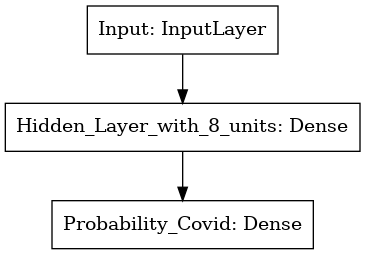

In [11]:
plot_model(model)

## Separação da base de dados em treino e teste

# Gráfico

In [12]:
index_max = (4*X.shape[0])//5
X_train = X[:index_max]
X_test = X[index_max+1:]
y_train = y[:index_max]
y_test = y[index_max+1:]

## Problemas computacionais

- Treino local ou na cloud?
- CPU ou GPU?
- Alocação de memória RAM
- Alocação de VRAM


In [13]:
del dados
del dados_dummy
del X
del y

## Escolha de otimizador e função de perda

In [14]:
model.compile(optimizer = Adam(), loss = BinaryCrossentropy())

In [15]:
batch_size = 1024
epochs = 200

params={
    "batch_size":batch_size,
    "epochs":epochs}
experiment.log_parameters(params)

In [16]:
with experiment.train():
    history = model.fit(x=X_train, y=y_train, batch_size = batch_size, epochs = epochs, 
                       validation_data=(X_test, y_test), shuffle=True)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/200
220/220 [==============================] - 0s 2ms/step - loss: 0.6403 - val_loss: 0.6067
Epoch 2/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6296 - val_loss: 0.5916
Epoch 3/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6214 - val_loss: 0.5834
Epoch 4/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6177 - val_loss: 0.5791
Epoch 5/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6163 - val_loss: 0.5785
Epoch 6/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6157 - val_loss: 0.5771
Epoch 7/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6154 - val_loss: 0.5785
Epoch 8/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6152 - val_loss: 0.5773
Epoch 9/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6151 - val_loss: 0.5781
Epoch 10/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6150 - val_lo

220/220 [==============================] - 0s 1ms/step - loss: 0.6124 - val_loss: 0.5751
Epoch 82/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6124 - val_loss: 0.5777
Epoch 83/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5771
Epoch 84/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5743
Epoch 85/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5744
Epoch 86/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6124 - val_loss: 0.5771
Epoch 87/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6124 - val_loss: 0.5779
Epoch 88/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5751
Epoch 89/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5759
Epoch 90/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 

Epoch 161/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.5738
Epoch 162/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.5746
Epoch 163/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.5741
Epoch 164/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6120 - val_loss: 0.5765
Epoch 165/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6120 - val_loss: 0.5744
Epoch 166/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.5761
Epoch 167/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6120 - val_loss: 0.5753
Epoch 168/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6120 - val_loss: 0.5761
Epoch 169/200
220/220 [==============================] - 0s 1ms/step - loss: 0.6121 - val_loss: 0.5736
Epoch 170/200
220/220 [==============================] - 0s 1ms/step - lo

In [17]:
model.save('rna_pre_treined.h5')
# model = load_model('rna_pre_treined.h5')

In [18]:
5# Predição para o treino
y_train_pred = model.predict(X_train)

In [19]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

In [20]:
roc_auc = auc(fpr, tpr)

{'web': 'https://www.comet.ml/api/image/download?imageId=f76c4313bfe542879acde8f4baa551e0&experimentKey=0745bc109bcb4267a73389b9350535d4',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=f76c4313bfe542879acde8f4baa551e0&experimentKey=0745bc109bcb4267a73389b9350535d4',
 'imageId': 'f76c4313bfe542879acde8f4baa551e0'}

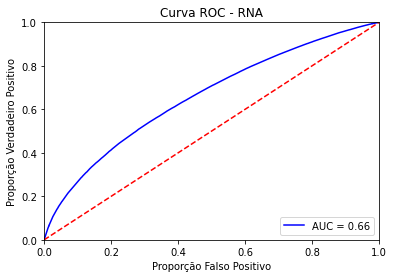

In [21]:
import matplotlib.pyplot as plt
plt.title('Curva ROC - RNA')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Proporção Verdadeiro Positivo')
plt.xlabel('Proporção Falso Positivo')
experiment.log_figure(figure=plt)

In [22]:
optimal_proba_cutoff = 0.3

## Matriz de confusão para o treino e para o teste

In [23]:
y_train_pred_class = (y_train_pred > optimal_proba_cutoff)*1
cm_train = confusion_matrix(y_train, y_train_pred_class, labels = [0,1])
sens_train = cm_train[0,0]/(cm_train[0,0] + cm_train[1,0])
print('Sensibilidade do treino: '+ str(sens_train))
esp_train = cm_train[1,1]/(cm_train[1,1] + cm_train[0,1])
print('Especificidade do treino: '+ str(esp_train))

acc_train = (cm_train[0,0]+cm_train[1,1])/(cm_train[0,0]+cm_train[0,1]+cm_train[1,0]+cm_train[1,1])
print('Acurácia no banco de treino: ' + str(acc_train))

experiment.log_confusion_matrix(matrix = cm_train, labels=['Negative', 'Positive'],
                               title = 'Matriz de confusão para o banco de treino',
                               file_name='treino.json')
experiment.log_metrics({'Sensibilidade treino':sens_train,
                       'Especificidade treino':esp_train,
                       'Acurácia treino':acc_train})

Sensibilidade do treino: 0.7656455508525241
Especificidade do treino: 0.4253407792686994
Acurácia no banco de treino: 0.5520816170216556


In [24]:
 'municipioIBGE'# Matriz de confusão pra teste
y_test_pred = model.predict(X_test)
y_test_pred_class = (y_test_pred > optimal_proba_cutoff)*1
cm_test = confusion_matrix(y_test, y_test_pred_class, labels = [0,1])
sens_test = cm_test[0,0]/(cm_test[0,0] + cm_test[1,0])
print('Sensibilidade do teste: '+ str(sens_test))
esp_test = cm_test[1,1]/(cm_test[1,1] + cm_test[0,1])
print('Especificidade do teste: '+ str(esp_test))

acc_test = (cm_test[0,0]+cm_test[1,1])/(cm_test[0,0]+cm_test[0,1]+cm_test[1,0]+cm_test[1,1])
print('Acurácia no banco de teste: ' + str(acc_test))

experiment.log_confusion_matrix(matrix = cm_test, labels=['Negative', 'Positive'],
                               title = 'Matriz de confusão para o banco de teste',
                               file_name='teste.json')
experiment.log_metrics({'Sensibilidade teste':sens_test,
                       'Especificidade teste':esp_test,
                       'Acurácia teste':acc_test})

Sensibilidade do teste: 0.8040864891478275
Especificidade do teste: 0.39865268989832214
Acurácia no banco de teste: 0.5746704666904168


In [25]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/martinoni/mae5904-rna/0745bc109bcb4267a73389b9350535d4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Acurácia teste             : 0.5746704666904168
COMET INFO:     Acurácia treino            : 0.5520816170216556
COMET INFO:     Especificidade teste       : 0.39865268989832214
COMET INFO:     Especificidade treino      : 0.4253407792686994
COMET INFO:     Sensibilidade teste        : 0.8040864891478275
COMET INFO:     Sensibilidade treino       : 0.7656455508525241
COMET INFO:     train_batch_loss [4400]    : (0.5794912576675415, 0.6480652689933777)
COMET INFO:     train_epoch_duration [200] : (0.2480935319999844, 0.7179053580002801)
COMET INFO:     train_loss [200]           : (0.6118329763412476, 0.6402546167373657)
COMET INFO:     t